In [1]:
import math
import sqlite3
import matplotlib.pyplot as plt
from html import escape
from IPython.core.display import HTML
from docutils.core import publish_parts
from itertools import groupby
from operator import itemgetter
from pathlib import Path

%matplotlib inline
plt.style.use('ggplot')

In [2]:
conn = sqlite3.connect('compression.db')

In [3]:
def render_rst(rst):
    """
    Given reStructuredText *rst*, return the rendered HTML
    content, excluding the surrounding outer-most ``<body>``
    elements.
    """
    return publish_parts(rst, writer_name='html')['html_body']

In [4]:
def render_table(sql, params=()):
    """
    Execute the query in *sql* and return string containing the result
    set rendered in an HTML ``<table>`` element.
    """
    cur = conn.execute(sql, params)
    columns = [r[0] for r in cur.description]
    rows = list(cur)
    cur.close()
    headers = "".join(
        f"<th>{escape(str(header).replace('_', ' ').title())}</th>"
        for header in columns
    )
    data = "\n".join(
        f"<tr>{html_row}</tr>"
        for row in rows
        for html_row in ("".join(
            f"<td>{escape(str(cell))}</td>"
            for cell in row
        ),)
    )
    return f"""
<table>
<thead><tr>{headers}</tr></thead>
<tbody>{data}</tbody>
</table>"""

In [5]:
def transpose(seq):
    return list(zip(*seq))

def render_xy(sql, params=(), ax=None, x_label='', y_label='',
              legend=True):
    """
    Execute the query in *sql* (with optional *params*) and plot the
    results on an X-Y scatter graph on axes *ax*. The query is expected
    to return at least 2 columns named "x" and "y".
    
    Optionally, a third column named "category" may be included which
    will be used to plot different coloured items. If this is used, the
    result set must be ordered by the category column.
    """
    style = {'marker': 'o', 'linestyle': 'none'}
    if ax is None:
        ax = plt.axes()
    cur = conn.execute(sql, params)
    cols = [c[0] for c in cur.description]
    x_col = cols.index('x')
    y_col = cols.index('y')
    getter = itemgetter(x_col, y_col)
    if 'category' in cols:
        cat_col = cols.index('category')
        data = {}
        for category, values in groupby(cur, key=itemgetter(cat_col)):
            results = transpose(getter(row) for row in values)
            ax.plot(results[0], results[1], label=category, **style)
        if legend:
            ax.legend()
    else:
        results = transpose(getter(row) for row in cur)
        ax.plot(results[0], results[1], **style)
    if x_label:
        ax.set_xlabel(x_label)
    if y_label:
        ax.set_ylabel(y_label)

In [6]:
HTML(render_rst(Path('README.rst').read_text()))

Name,Type,Description
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
Name,Type,Description
machine,TEXT,The label provided on by --machine on the command line
arch,TEXT,The dpkg architecture of the machine
compressor,TEXT,The name of the compressor
options,TEXT,The options to execute the compressor with (if any)
level,TEXT,The compression level to use
succeeded,INTEGER,"1 if the compression run succeeded, and 0 if it failed"


### Combinations tested

A list of all the machines (and architectures) tested:

In [7]:
HTML(render_table("""
SELECT DISTINCT machine, arch
FROM results
"""))

Machine,Arch
AMD Opteron 8GB,amd64
AMD Ryzen 32GB,amd64
Pi 4 8GB,arm64
Pi 4 8GB,armhf
Pi Zero 2 512MB,arm64
Pi Zero 2 512MB,armhf


A list of all the compressors and options tested:

In [8]:
HTML(render_table("""
SELECT compressor, options, GROUP_CONCAT(level) AS levels
FROM tests
GROUP BY compressor, options
ORDER BY compressor, options
"""))

Compressor,Options,Levels
gzip,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
lz4,,"-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
xz,-e,"-0,-1,-2,-3,-4,-5,-6,-7,-8,-9"
zstd,,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9"
zstd,-T0,"-1,-10,-11,-12,-13,-14,-15,-16,-17,-18,-19,-2,-3,-4,-5,-6,-7,-8,-9"


The ``-e`` option for ``xz`` enables "extreme" (!) compression, whilst the ``-T0`` option for ``zstd`` enables multi-threaded operation.

### Dangerous combinations

Show all compressor+option combinations that failed to produce a result

In [9]:
HTML(render_table("""
SELECT machine, arch, compressor, options, level
FROM results
WHERE succeeded = 0
"""))

Machine,Arch,Compressor,Options,Level
Pi Zero 2 512MB,armhf,xz,,-8
Pi Zero 2 512MB,armhf,xz,,-9
Pi Zero 2 512MB,armhf,xz,-e,-8
Pi Zero 2 512MB,armhf,xz,-e,-9
Pi Zero 2 512MB,armhf,zstd,-T0,-14
Pi Zero 2 512MB,armhf,zstd,-T0,-15
Pi Zero 2 512MB,armhf,zstd,-T0,-19
Pi Zero 2 512MB,arm64,xz,,-7
Pi Zero 2 512MB,arm64,xz,,-8
Pi Zero 2 512MB,arm64,xz,,-9


From the table above we can see that only the Pi Zero 2 has an issue, and that only the more aggressive options of ``xz`` and ``zstd`` tend to cause a direct failure. However, it's worth bearing in mind that these tests were run on otherwise idle and unloaded systems. We should strive to be as minimal as possible in our memory usage so as not to pressure concurrent services into OOM failure.

On the Pi Zero 2 (and 3A+) with the arm64 architecture, the typical amount of RAM available at runtime with all "default" services loaded (systemd et al), and with the typical firmware stack loaded (which allocates 64MB to the GPU), is only around 200MB. Anything that takes >20MB of resident memory is therefore eating at least 10% of the RAM available, and could be considered a "bad idea".

## Compression comparisons

A quick look at how well the various options perform. We'll query only those combinations that succeeded, limited to those that took less than 20s (otherwise `xz` squishes everything into a corner!), categorize by the compressor, and limit output to a single machine (and architecture) per graph (with shared axes) at a time for ease of comparison:

In [10]:
machines = list(
    conn.execute("SELECT DISTINCT machine, arch FROM results"))

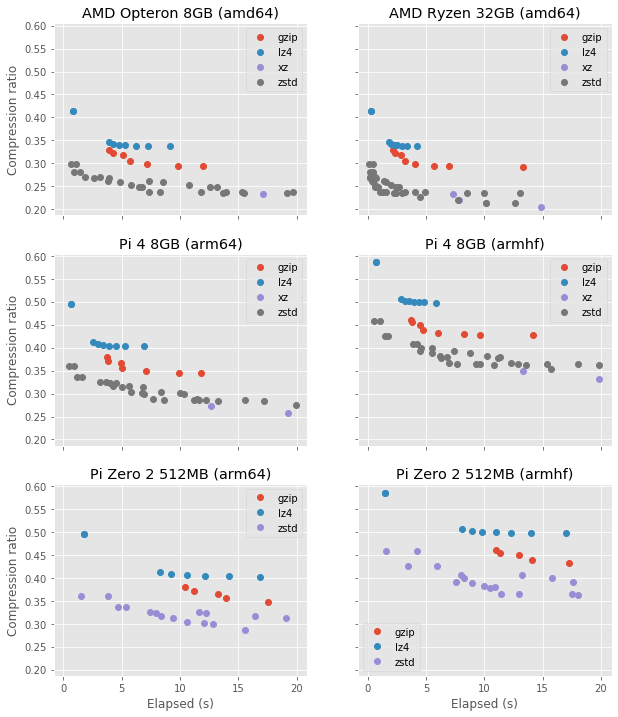

In [11]:
query = """
SELECT elapsed AS x, ratio AS y, compressor AS category
FROM results
WHERE succeeded = 1
AND machine = ?
AND arch = ?
AND elapsed < 20
ORDER BY compressor
"""
fig, axs = plt.subplots(
    math.ceil(len(machines) / 2), 2, figsize=(10, 12),
    sharex=True, sharey=True)
for ax, (machine, arch) in zip(axs.flat, machines):
    render_xy(query, params=(machine, arch), ax=ax,
              x_label='Elapsed (s)',
              y_label='Compression ratio')
    ax.set_title(f'{machine} ({arch})')
    ax.label_outer()
if len(machines) % 2:
    axs.flat[-1].set(visible=False)

From the above, we can conclude:

* The patterns are fairly obvious: higher compression takes more time; each "sweep" of dots indicates a predictable continuum from `-1` up to `-9` (or whatever the range of compression levels are for a given compressor)

* `xz` is hopelessly slow; almost all its points are missing as they take more than 20s even on large-scale PCs, and even at minimal compression levels

* `lz4` was probably a mis-step. Whilst it's extremely fast at the `-1` end, it was hard-coded in `update-initramfs` with `-9` and at that level, even `gzip -1` beats it at compression, and is considerably faster¹

* `zstd -1` beats the compression ratio of `gzip` at most levels, and is within spitting distance of `lz4 -1` for speed (and consistently faster than `lz4 -2`)

¹ Perhaps there was a win in decompression speed (which I haven't measured here), but even then it would have to overcome the extra I/O time required by the reduced compression.

## Memory pressure

How about the maximum resident size of each compressor at various levels? We'll discount `xz` from the analysis as it's already rejected by the analysis above, and limit the query to anything less than 100MB (otherwise `zstd` squashes everything into a corner, particularly when running multi-threaded):

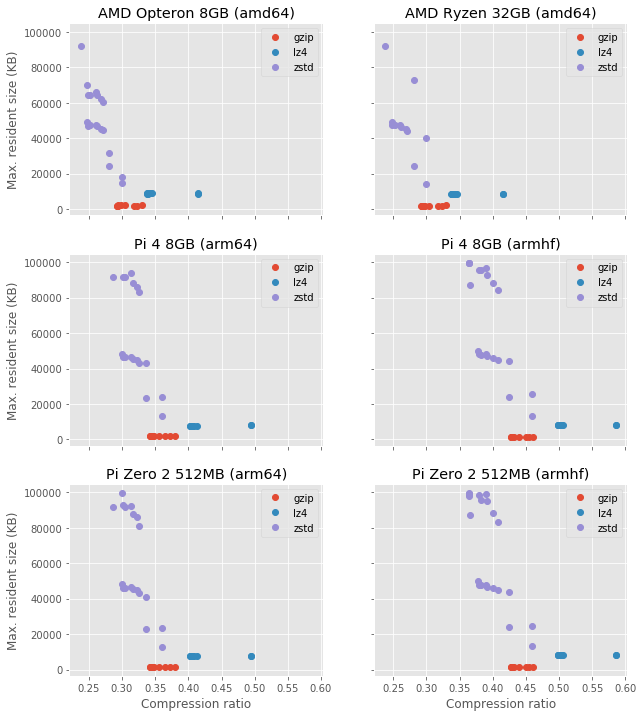

In [12]:
query = """
SELECT ratio AS x, max_resident AS y, compressor AS category
FROM results
WHERE succeeded = 1
AND machine = ?
AND arch = ?
AND max_resident < 100000
AND compressor <> 'xz'
ORDER BY compressor
"""
fig, axs = plt.subplots(
    math.ceil(len(machines) / 2), 2, figsize=(10, 12),
    sharex=True, sharey=True)
for ax, (machine, arch) in zip(axs.flat, machines):
    render_xy(query, params=(machine, arch), ax=ax,
              x_label='Compression ratio',
              y_label='Max. resident size (KB)')
    ax.set_title(f'{machine} ({arch})')
    ax.label_outer()
if len(machines) % 2:
    axs.flat[-1].set(visible=False)

`lz4` and `gzip` both clearly stick within fixed bounds no matter what compression level has been selected. Interestingly, `gzip` is also the "safest" implementation (at least from a memory usage perspective), using the smallest RSS. `zstd` varies over an extremely wide range depending on the level selected, only approaching the smaller resident sizes of `lz4` and `gzip` at the smallest levels. However, it also achieves notable compression gains over `lz4` (and `gzip`, mostly) even at those low levels.

## Automation

Would it be possible to design some algorithm that, given an architecture and perhaps a memory size, selects an appropriate compression level (and possibly algorithm) automatically? My gut feeling is "no", and further that, even if the answer were "maybe", the result would be a maintenance nightmare. Still, let's see if there's any discernable pattern in the overall data anyway:

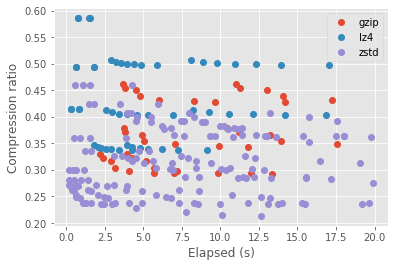

In [13]:
query = """
SELECT elapsed AS x, ratio AS y, compressor AS category
FROM results
WHERE succeeded = 1
AND compressor <> 'xz'
AND elapsed < 20
ORDER BY compressor
"""
render_xy(query,
          x_label='Elapsed (s)',
          y_label='Compression ratio')

From the above there is a pattern, but with sufficient overlap in the performance of various compressors at various levels that any automatic algorithm would have to be per-architecture and possibly per-machine-size. That would either involve a corpus of data (which would need to be maintained in the face of advances in technology), or similar tuning parameters (which likewise would require future maintenance).

## Limits

Some additional queries to flesh out my general impression that `zstd -1` is by far the most preferable compression default:

In [14]:
HTML(render_table("""
SELECT
    compressor,
    level,
    MIN(elapsed) AS best_speed,
    MAX(elapsed) AS worst_speed,
    MIN(ratio) AS best_ratio,
    MAX(ratio) AS worst_ratio
FROM results
WHERE succeeded = 1
AND (
    (compressor = 'zstd' AND level IN ('-1', '-19') AND options = '')
    OR
    (compressor = 'lz4' AND level = '-9')
)
GROUP BY compressor, level
ORDER BY compressor DESC, level ASC
"""))

Compressor,Level,Best Speed,Worst Speed,Best Ratio,Worst Ratio
zstd,-1,0.45,4.25,0.2993680214185393,0.45910836037587366
zstd,-19,43.84,197.73,0.2133113917661517,0.32504361138494475
lz4,-9,4.26,22.21,0.33763590129037924,0.49830905895132765


`zstd -1` has a best time of less than a second, and a worst of no more than 5s, and it varies between compressing to roughly 30-45% of the original size.

Compare this to the prior defaults of `lz4 -9` and `zstd -19`, and bear in mind the above is across *all* architectures. The worst time of `zstd -1` (presumably on the little Pi Zero 2) is still better than the best time of `lz4 -9` (on the big fat AMD Ryzen), and while we do potentially sacrifice some compression ratio, it's still typically better than the prior `lz4 -9` default. But let's answer that more specifically:

Are there specific cases where the compression ratio of `zstd -1` is worse than `lz4 -9`, or where the elapsed time is slower?

In [15]:
HTML(render_table("""
WITH lz4_9 AS (
    SELECT * FROM results
    WHERE compressor = 'lz4' AND level = '-9'
),
zstd_1 AS (
    SELECT * FROM results
    WHERE compressor = 'zstd' AND options = '' AND level = '-1'
)
SELECT l.machine, l.arch, l.ratio, z.ratio, l.elapsed, z.elapsed
FROM lz4_9 AS l JOIN zstd_1 AS z USING (machine, arch)
WHERE l.ratio < z.ratio
OR l.elapsed < z.elapsed
"""))

Machine,Arch,Ratio,Ratio,Elapsed,Elapsed


Nope!

## Conclusion

It's indisputable that `zstd -19` provides the best compression of our available options, but it does so at the cost of a pretty extraordinary amount of memory usage (particularly compared to its forebears), making it unsafe on the smaller platforms.

Whilst it may be tempting to try and eek every last byte of compression out of the system, doing so would also impose a maintenance cost and, in light of the results above, I believe a considerable one. By comparison, switching to `zstd -1` is a win in elapsed time, memory used, and compression achieved (at least compared to the prior `lz4 -9` default).